# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 5: Regularization, Model Selection, and Confidence Intervals 

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

**Material preparation**: Robert Roessler, Queenie Luo

In [1]:
# Data and Stats packages
import numpy as np
import pandas as pd
#pd.set_option('max_columns', 200)

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
#from prettytable import PrettyTable

In [2]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import sys

In [3]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["Times New Roman"],
    "figure.dpi" : 100})

# to display nice pipeline drawing
from sklearn import set_config
set_config(display="diagram") # instead of display='text'
pd.set_option('display.max_columns', None)

<a id=top></a>
### Lab Overview

- [1 - Cross Validation](#cv)<BR>
- [2 - Bootstrapping](#boot)<BR>
- [3 - Confidence Intervals](#ci)<BR>
- [4 - Feature importance](#feature)<BR>
- [5 - Linear Regression Coefficient interpretation](#coeff_interpretation)<BR>
- [6 - Model Selection review with an example of ridge and lasso regression using cross validation.](#model)<BR>

### The dataset
We are revisiting the dataset from last week's lab, which focused on Premier League Soccer Data. With this dataset, our primary objective was to predict the market value of Premier League players, denominated in millions of pounds, based on a variety of features.

In the previous lab, you learned about the critical preparatory steps before model training. This involved feature engineering, where transformations such as `OneHotEncoder()` might be applied to handle categorical data. We also introduced the `PolynomialFeatures()` method, which allowed us to generate higher-degree features as well as interaction terms, capturing relationships between different features. Most importantly, we emphasized the importance of standardizing the features using techniques like the `StandardScaler()` to ensure that our model treats all features on a common scale. The data we're loading now is the outcome of those efforts.

In [4]:
# Loading the data
design_train_df = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")  # you could add .values.ravel() to make sure y_train is a 1D array

design_test_df = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

display(design_train_df.head(5))
design_train_df.shape

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,-0.378867,-0.705517,-0.689254,0.143541,0.267297,0.261136,0.497754,0.486280,0.475071,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.649806,-0.782937,-0.689254,0.422248,0.508758,0.447882,0.612991,0.539642,0.475071,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.090449,0.533214,0.074738,0.008181,-0.048228,-0.006760,0.284317,0.039852,0.005586,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.558494,1.636458,-0.434590,0.311916,0.913952,-0.242716,2.677993,-0.711188,0.188868,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.271168,2.352598,-0.434590,0.073532,0.637948,-0.117847,5.534719,-1.022415,0.188868,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


(368, 17)

<div id=cv style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>1 - Cross Validation</h1> 


### Intro

Cross-validation is a technique for evaluating predictive models. In k-fold cross-validation, the dataset is divided into k subsets or folds. The model is trained and evaluated k times, using a different fold as the validation set each time. Performance metrics from each fold are averaged to estimate the model's generalization performance.


<img src="fig/cross_val.png" alt="alt text" width="500" height="300" class="blog-image">



---

### Key Points for Cross Validation

<div style="padding-top:0px;"></div>

1. **Role of Training, Validation, and Test Sets:**
    - **Key Takeaway:** The training set is used to fit candidate models, their performance on the validation set is used to select from among candidates, and the selected model's performance is finally evaluated on the test set.
    - **Rationale:** Use of a validation set for model selection prevents overfitting to the training data. A separate test set helps us estimate the selected model's performance on previously unseen data.

<div style="padding-top:0px;"></div>

2. **$k$-Fold Cross Validation:**
    - **Key Takeaway:** One common method of model selection is $k$-Fold cross-validation where the original training data is partitioned into $k$ subsets or 'folds.' The model is trained on $k$-1 folds and validated on the remaining one. This process is repeated K times.
    - **Rationale:** By rotating the validation set through all data points, we can get a more consistent measure of model performance.

<div style="padding-top:0px;"></div>

3. **Choosing the Right Number of Folds:**
    - **Key Takeaway:** The choice of $k$ in $k$-Fold cross-validation is crucial. Common choices are 5 or 10, but the optimal number may vary depending on the dataset size and specific problem.
    - **Rationale:** A smaller $k$ will result in larger validation sets, which gives more accurate estimates of model performance but with higher variance. A larger $k$ provides smaller validation sets, leading to a less accurate model performance estimate but with lower variance.

---

### Manual Implementation of k-fold Cross-Validation

<div class="alert alert-success">
<h3>Interactive Coding Section</h3> 

Think along and help me fill out the missing lines of code

In [5]:
# K-Fold cross-validation

# Number of partitions/folds to divide the dataset into
k = 8

# Calculate the size of each fold. If the dataset's length isn't 
# perfectly divisible by k, some folds might have an extra data point.
fold_size = len(design_train_df) // k

# This list will store the mean squared error for each fold.
all_mse = []

# Iterate over each fold
for i in range(k):

    # Compute the starting and ending indices for the test set based on the current fold.
    # For example, if fold_size is 100:
    # i=0 -> start=0, end=100
    # i=1 -> start=100, end=200
    # ... and so on
    start, end = i * fold_size, (i + 1) * fold_size

    print(start, end)
    
    # Use slicing to get the test set for the current fold from the main dataset.
    X_val_fold = design_train_df[start:end] # TODO
    y_val_fold = y_train[start:end] # TODO

    # TODO: EXPLAIN WHAT'S GOING ON HERE!
    X_train_fold = pd.concat([design_train_df[:start], design_train_df[end:]])
    y_train_fold = np.concatenate([y_train[:start], y_train[end:]])

    # Initialize a linear regression model
    model = LinearRegression()
    
    # Train the model using the training set
    model.fit(X_train_fold, y_train_fold) #TODO
    
    # Predict the target values for the test set
    predictions = model.predict(X_val_fold) # TODO

    # Compute the mean squared error for the current fold's predictions
    mse = mean_squared_error(y_val_fold, predictions) # TODO

    # Store the computed MSE to our list
    all_mse.append(mse)

# Calculate the average mean squared error across all folds.
avg_mse = np.mean(all_mse)

# Print the result
print(f"Average MSE from simplified scratch implementation: {avg_mse:.2f}")


0 46
46 92
92 138
138 184
184 230
230 276
276 322
322 368
Average MSE from simplified scratch implementation: 40.17


### K-fold Cross-Validation with scikit-learn's 'cross_validate()'

In [6]:
# Using cross_validate function on training data
model = LinearRegression()
scores = cross_validate(model, design_train_df, y_train, cv=8, scoring='neg_mean_squared_error') # negative MSE because it's a loss function

avg_mse_sklearn = -np.mean(scores['test_score'])  # Convert negative MSE back to positive
print(f"Average MSE using scikit-learn: {avg_mse_sklearn:.2f}")


Average MSE using scikit-learn: 40.17


---

### You might be wondering:

**"why neg_mean_squared_error"?**
  
*Answer:* In Scikit-learn, a general principle is that greater values should always correspond to better outcomes. This makes sense when thinking about scores like accuracy or R^2 where higher values are obviously better. However, when it comes to loss functions like Mean Squared Error (MSE), a lower value is better. So, to make it fit into Scikit-learn's general principle, the negative of the MSE is used. This way, larger values (which are less negative) still indicate better models. This principle is embedded in Scikit-learn's unified scoring API. 
When you perform hyperparameter tuning using something like GridSearchCV or RandomizedSearchCV, Scikit-learn tries to maximize the score. If you used a positive MSE, the optimization routine would erroneously try to maximize the MSE, which isn't what we want. By using a negative MSE, the optimization correctly tries to find a model that gets the "maximum" score, which corresponds to the minimum actual MSE.

**"Why use K-Fold and not e.g. LPOCV or LOOCV (Leave-P-Out or Leave-One-Out Cross Validation)?"**

*Answer:* LOOCV can be computationally expensive for large datasets, as it involves training a model n times (where n is the number of data points). K-Fold, especially with k=5 or 10, provides a good balance between computational cost and reliable estimation of model performance.

**In the manual cross-validation example, why didn't we shuffle the data?**

*Answer:* The manual example was a simplified demonstration. In many real-world scenarios, especially if the data has some order to it, you'd want to shuffle the data or use StratifiedKFold to maintain class distributions.

<div id=boot style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>2 - Bootstrapping</h1> 


<img src="fig/bootstrap_example_rader.jpeg" alt="alt text" width="500" height="300" class="blog-image">


---

### Key Points for Bootstrapping:

1. **Sample Size Consistency:** 
    - **Key Takeaway:** The bootstrap dataset should have the same number of points as the original.
    - **Rationale:** This preserves the structure and variability of the original dataset in the bootstrap samples, ensuring that we are drawing from a distribution similar to our original data.

<div style="padding-top:0px;"></div>

2. **Sampling with Replacement:** 
    - **Key Takeaway:** We must sample with replacement; each time an item is selected, we put it back in the original dataset, so it may possibly be reselected.
    - **Rationale:** By sampling with replacement, each bootstrap sample is an independent draw from the original dataset. This captures the idea that we are trying to emulate the process of obtaining new samples from the population.

<div style="padding-top:0px;"></div>

3. **Extensive Iterative Sampling for Robust Bootstrapping Results:**
    - **Key Takeaway:** Typically, thousands of bootstrap samples are drawn (e.g., 10,000 or more) to obtain a reliable estimate of the distribution.
    - **Rationale:** The more replicates we draw, the better our approximation to the true distribution of the statistic. This ensures that our estimates, such as confidence intervals, are robust and reliable.

<div style="padding-top:0px;"></div>

4. **Limitations and Assumptions of Bootstrapping:**
    - **Key Takeaway:** While bootstrapping is versatile and powerful, it's not always the best approach for every situation.
    - **Rationale:** The bootstrap method assumes that the sample is a good representation of the population. If the original sample has biases or is not representative, the bootstrap samples will inherit these issues. 

<div style="padding-top:0px;"></div>

5. **Bootstrap and Confidence Intervals:**
    - **Key Takeaway:** One common use of bootstrapping is to construct confidence intervals, which provide a range of values that likely contain the true parameter value.
    - **Rationale:** Bootstrapped confidence intervals give a non-parametric way to estimate the range of possible values for a statistic without making strong assumptions about the shape or parameters of the true population distribution.

---

### Bootstrap Implementation 
#### The laborious, but insightful way:

1. Choose random data points by randomly choosing indices.
2. Create subsets of the original data by choosing the DataFrame elements with the randomly chosen indices.

This could be achieved by using numpy's `random.choice()` pandas' `.iloc[]` method.

In [7]:
# Create example df  
example_X_df = design_train_df.head(5)
example_y_df = y_train.head(5)

# Generate random indices from example df
boot_i = np.random.choice(example_X_df.index, replace = True, size = len(example_X_df.index)) 

# Generate an X_train_boot data frame that contains exactly the observations with the boot_i indices.
# Print out the results of each line to understand what's going on. 
# Make sure that you understand why X_train_boot can contain the same index multiple times
X_train_boot = example_X_df.iloc[boot_i]
y_train_boot = example_y_df.iloc[boot_i]

#display(X_train_boot)
#display(y_train_boot)

#### The fast way (if your training data wasn't split into X and y):

1. Instead of calculating indices manually and using .iloc to grab the respective rows, you could also use pandas' built-in `.sample()` method
2. However, since you don't have the indices to also grab the respective y_train_boot values in this case, you'd have to combine example_df and y_train

In [8]:
# Create an example dataframe
example_X_df = design_train_df.head(5)

# Take the corresponding rows from y_train and add it to the example_df
example_X_y_df = example_X_df.copy()
example_X_y_df['target'] = y_train.head(5)

# Bootstrapping using pandas' sample method
boot_df = example_X_y_df.sample(frac=1, replace=True)

# Split the bootstrapped dataframe back into X_train_boot and y_train_boot
X_train_boot = boot_df.drop(columns='target')
y_train_boot = boot_df['target']

# display(X_train_boot)
# display(y_train_boot)

<div class="alert alert-success">
<h3>Your turn! (10 mins)</h3> 

Complete the code inside the loop below. Make sure to create a new bootstrap sample in every iteration, fit a linear regression model. Store the model in `boot_models` as well as the coefficients.

In [9]:
# Configure number of bootstraps
n_boots = 1000

# Lists to save models and coefficients
boot_models = []
boot_betas = []

# Decision to add intercept in the linear regression model
fit_intercept = True

for i in range(n_boots):
   
    # Randomly sample indices with replacement to create bootstrap samples
    boot_i = np.random.choice(example_X_df.index, replace = True, size = len(example_X_df.index)) # TODO

    # Create bootstrap datasets for features and target variable using the sampled indices
    X_train_boot = design_train_df.iloc[boot_i] # TODO
    y_train_boot = y_train.iloc[boot_i] # TODO
    
    # Train a linear regression model on the bootstrap sample
    boot_linreg = LinearRegression(fit_intercept = fit_intercept).fit(X_train_boot, y_train_boot) # TODO

    # Save the trained model
    boot_models.append(boot_linreg) # TODO
    
    # EXPLAIN AND COMMENT THE FOLLOWING NEXT TWO LINES
    coefs = np.insert(boot_linreg.coef_[0], 0, boot_linreg.intercept_[0], axis=None)
    boot_betas.append(coefs)

In [10]:
# store betas in df
boot_betas_df = pd.DataFrame(boot_betas) 

<div class="alert alert-success">
<h3>Next Steps</h3> 

if you have some time left, look into the following next steps. We will do this interactively in class.

1. **Examine the Coefficients:** Take a closer look at the boot_betas to understand the distribution and variability of our bootstrapped coefficients.

2. **Comparing Columns:** Determine the number of columns in boot_betas & the number of columns in design_train_df.

<div style='padding:0px'></div>

3. **Investigate Discrepancies:** Can you explain the difference in the number of columns between boot_betas and design_train_df?
  
<div style='padding:0px'></div>

4. **Action Plan:** What steps do you think we need to take next, based on the results and discrepancies you've observed? List them in order.

### Explore

In [11]:
 display(boot_betas_df.head())
 print(len(boot_betas_df.columns)) 
 display(design_train_df.columns)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,8.563453,0.340534,-1.226513,-1.201781,-0.495598,-0.018483,-0.107682,1.061756,0.296812,0.712691,-1.639388,-2.524392,3.964701,-2.524392,0.000000,-3.964701,0.0,0.0
1,20.842862,5.231716,5.437092,1.005790,1.934066,4.023294,-2.654711,-6.597409,-3.072506,-1.130351,0.000000,0.000000,5.323654,0.000000,9.273133,3.949479,0.0,0.0
2,1.622668,2.186561,3.845450,-1.293988,0.786237,2.755504,-0.883205,7.225950,-2.478783,0.397369,-2.716036,-0.350914,3.066950,-0.350914,3.066950,0.000000,0.0,0.0
3,13.125740,0.812616,0.184647,-0.004216,-0.845829,-0.739930,-0.561242,-0.433600,-0.137188,0.004739,0.000000,-3.038980,3.055537,-3.038980,0.000000,-3.055537,0.0,0.0
4,1.622668,2.186561,3.845450,-1.293988,0.786237,2.755504,-0.883205,7.225950,-2.478783,0.397369,-2.716036,-0.350914,3.066950,-0.350914,3.066950,0.000000,0.0,0.0


18


Index(['page_views', 'fpl_points', 'age', 'page_views^2',
       'page_views fpl_points', 'page_views age', 'fpl_points^2',
       'fpl_points age', 'age^2', 'position_cat_2', 'position_cat_3',
       'position_cat_4', 'new_signing_1', 'big_club_1', 'region_2', 'region_3',
       'region_4'],
      dtype='object')

### Task 
Recover the feature names for each beta coefficient and add them to the data frame. Don't forget the intercept!

In [12]:
# Extracting the feature names from the design_train_df
feature_names = list(design_train_df.columns)

# Adding 'x0' to the beginning of the list, representing the intercept in our linear model
feature_names_final = ['x0'] + feature_names

# Creating a DataFrame to store the coefficients from all bootstrap models
# Each row in boot_betas_df represents the coefficients (including the intercept) from one bootstrap model
boot_betas_df = pd.DataFrame(boot_betas, columns=feature_names_final) 

boot_betas_df

,x0,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,8.563453,0.340534,-1.226513,-1.201781,-0.495598,-0.018483,-0.107682,1.061756,0.296812,0.712691,-1.639388,-2.524392,3.964701,-2.524392,0.000000,-3.964701,0.0,0.0
1,20.842862,5.231716,5.437092,1.005790,1.934066,4.023294,-2.654711,-6.597409,-3.072506,-1.130351,0.000000,0.000000,5.323654,0.000000,9.273133,3.949479,0.0,0.0
2,1.622668,2.186561,3.845450,-1.293988,0.786237,2.755504,-0.883205,7.225950,-2.478783,0.397369,-2.716036,-0.350914,3.066950,-0.350914,3.066950,0.000000,0.0,0.0
3,13.125740,0.812616,0.184647,-0.004216,-0.845829,-0.739930,-0.561242,-0.433600,-0.137188,0.004739,0.000000,-3.038980,3.055537,-3.038980,0.000000,-3.055537,0.0,0.0
4,1.622668,2.186561,3.845450,-1.293988,0.786237,2.755504,-0.883205,7.225950,-2.478783,0.397369,-2.716036,-0.350914,3.066950,-0.350914,3.066950,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,13.125740,0.812616,0.184647,-0.004216,-0.845829,-0.739930,-0.561242,-0.433600,-0.137188,0.004739,0.000000,-3.038980,3.055537,-3.038980,0.000000,-3.055537,0.0,0.0
996,6.712253,2.183373,2.216736,-2.090299,0.351396,2.443568,-0.850337,6.668996,-1.851096,0.919172,-3.674926,-2.225645,5.900571,-2.225645,2.816712,-3.083859,0.0,0.0
997,7.553985,5.570383,3.025673,-2.240368,2.694129,6.414691,-2.321852,-3.010264,-2.753427,0.664617,-4.762522,-0.727698,11.060547,-0.727698,11.060547,0.000000,0.0,0.0
998,2.150784,0.105299,0.405842,-0.019923,-0.023591,0.065914,-0.055745,0.829759,-0.214728,-0.008927,-0.080483,-0.082733,0.000000,-0.082733,0.000000,0.000000,0.0,0.0


<div id=ci style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>3 - Confidence Intervals</h1> 


After bootstrapping and obtaining a distribution of coefficients for each feature, a logical next step is to compute confidence intervals. Confidence intervals provide a range of values, derived from the bootstrapped data, in which we expect the true parameter (in this case, the coefficient) to lie, with a certain level of confidence.

**Why is this useful?**

- **Interpretability**: Confidence intervals help us understand the uncertainty and variability associated with our estimates. A narrower confidence interval indicates a more reliable estimate, while a wider interval suggests more uncertainty.
  
- **Statistical Significance**: By examining whether a confidence interval for a coefficient includes zero, we can make inferences about the statistical significance of that coefficient. If zero isn't in the interval, we might infer the corresponding feature has a significant association with the target.

- **Comparisons**: By comparing the confidence intervals of different coefficients, we can gauge which features have more influence or certainty associated with their effects.

In the following code, we will compute the 95% confidence intervals for each feature's coefficient. This means that we are 95% confident that the true coefficient lies within the provided range.

---


<div class="alert alert-success">
<h3>TASK: Find the 95% confidence intervals for the coefficients</h3> 

In [13]:
# Initialize an empty list to store statistics for each feature
stats_list = []

# Loop through each feature to compute its bootstrapped statistics
for i in range(len(feature_names_final)):
    
    # Extracting the bootstrapped coefficient values for the current feature
    betavals = boot_betas_df.iloc[:, i]
    
    # Sorting the coefficient values to aid in percentile calculation
    betavals.values.sort()
    
    # TODO: COMPLETE AND EXPLAIN WHAT'S HAPPENING IN THE FOLLOWING TWO LINES
    x1 = np.round(np.percentile(betavals, 2.5), 2)
    x2 = np.round(np.percentile(betavals, 97.5), 2)
    
    # Calculating mean and standard deviation of the bootstrapped coefficients
    mean = np.round(np.mean(betavals),2)
    std = np.round(np.std(betavals),2)
    
    # Appending computed statistics for current feature to the stats_list
    stats_list.append([feature_names_final[i], mean, std, x1, x2])

# Convert the stats_list into a dataframe for easy visualization and analysis
boot_beta_df = pd.DataFrame(stats_list, columns=['feature', 'boot_mean', 'boot_std', '95_low', '95_high'])

# Display the final dataframe with bootstrapped statistics and confidence intervals
boot_beta_df

,feature,boot_mean,boot_std,95_low,95_high
0,x0,10.42,7.27,1.62,22.97
1,page_views,2.84,2.40,-0.56,5.83
2,fpl_points,2.14,2.46,-2.35,5.86
3,age,-1.03,1.31,-2.77,1.01
4,page_views^2,0.92,1.26,-0.85,2.97
5,page_views fpl_points,2.77,2.51,-0.74,6.76
6,page_views age,-1.29,1.14,-3.08,0.55
7,fpl_points^2,0.07,4.61,-6.60,7.23
8,fpl_points age,-1.65,1.38,-3.31,0.78
9,age^2,0.28,0.77,-1.14,1.21


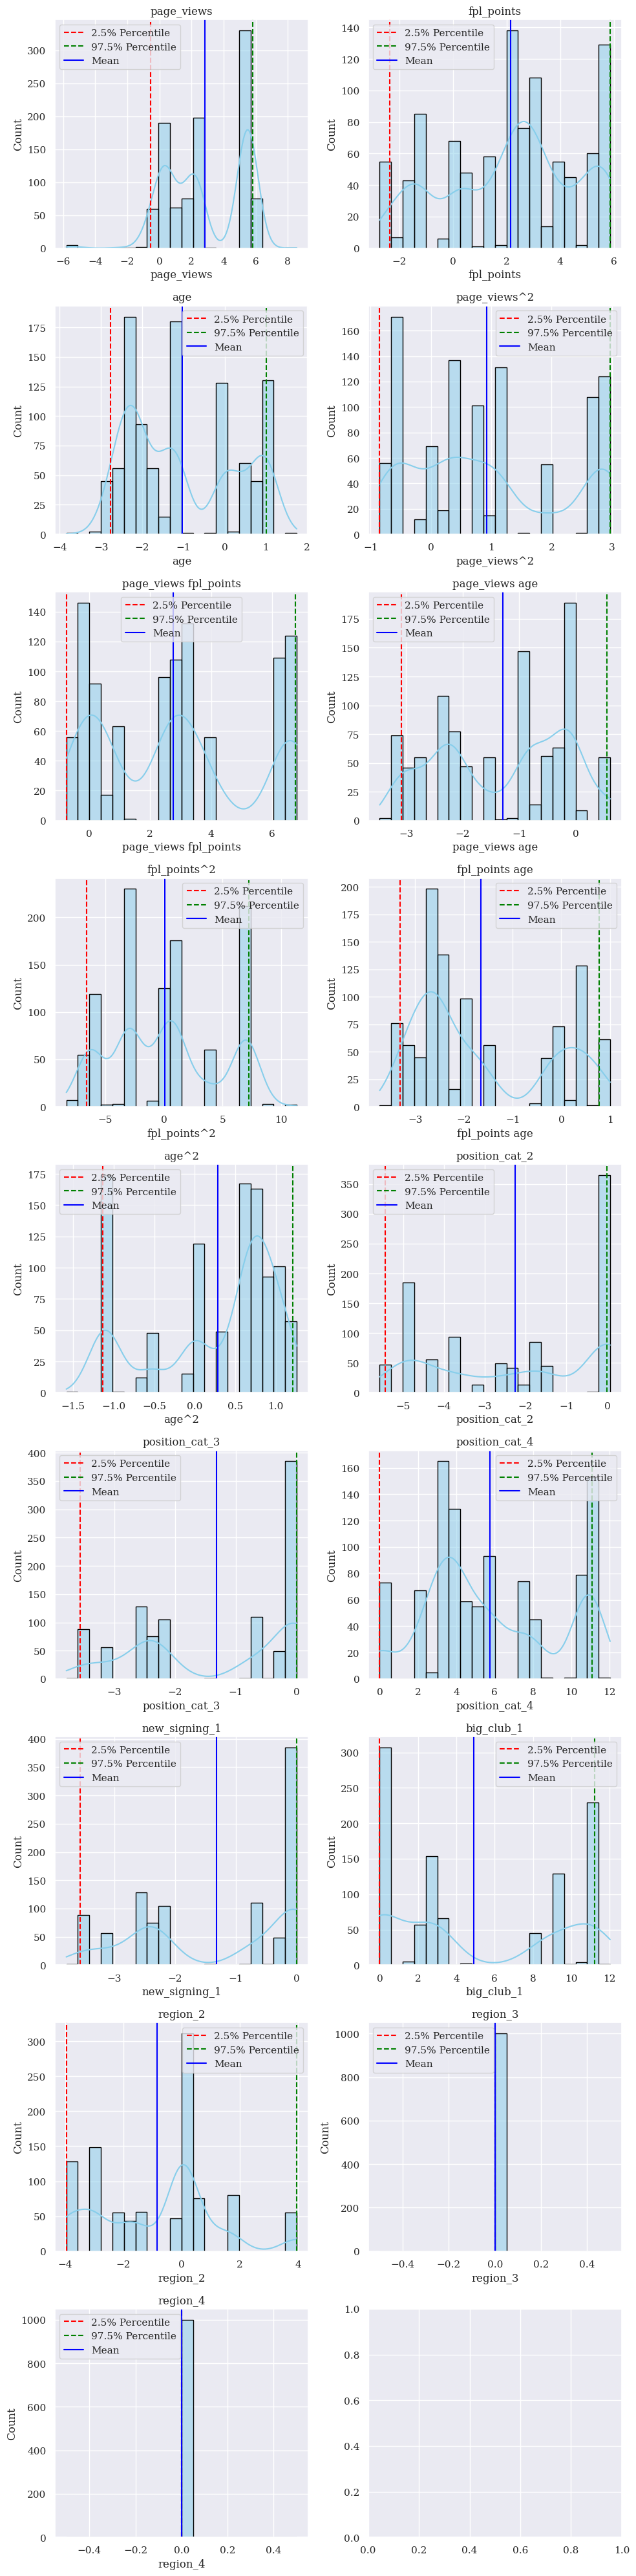

In [14]:
# Setting up the figure and axes
fig, axs = plt.subplots(9, 2, figsize=(10, 40))
axs = axs.ravel()

# Looping through each feature to plot histograms and confidence intervals
# Starting from 1 to exclude the intercept (assuming x0 is the first column)
for i, (index, row) in enumerate(boot_beta_df.iloc[1:].iterrows()):
    sns.histplot(boot_betas_df.iloc[:, i+1], bins = 20, ax=axs[i], kde=True, color='skyblue', edgecolor='black')
    axs[i].axvline(row['95_low'], color='red', linestyle='--', label='2.5% Percentile')
    axs[i].axvline(row['95_high'], color='green', linestyle='--', label='97.5% Percentile')
    axs[i].axvline(row['boot_mean'], color='blue', linestyle='-', label='Mean')
    axs[i].set_title(row['feature'])
    axs[i].legend()

# Adjusting layout
plt.tight_layout()
plt.show()

#### Now let's plot the confidence intervals for a couple of the feature coefficients

<div id=feature style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>4 - Feature importance</h1> 

Let's see how important our vaues are from the bootstrap values in DataFrame `boot_beta_df`. Sort the values.

In [15]:
sorted_boot_beta_df = boot_beta_df.sort_values(by=['boot_mean'], ascending=True)
sorted_boot_beta_df

,feature,boot_mean,boot_std,95_low,95_high
10,position_cat_2,-2.26,2.03,-5.44,0.00
8,fpl_points age,-1.65,1.38,-3.31,0.78
13,new_signing_1,-1.32,1.30,-3.56,0.00
11,position_cat_3,-1.32,1.30,-3.56,0.00
6,page_views age,-1.29,1.14,-3.08,0.55
3,age,-1.03,1.31,-2.77,1.01
15,region_2,-0.85,2.06,-3.96,3.95
16,region_3,0.00,0.00,0.00,0.00
17,region_4,0.00,0.00,0.00,0.00
7,fpl_points^2,0.07,4.61,-6.60,7.23


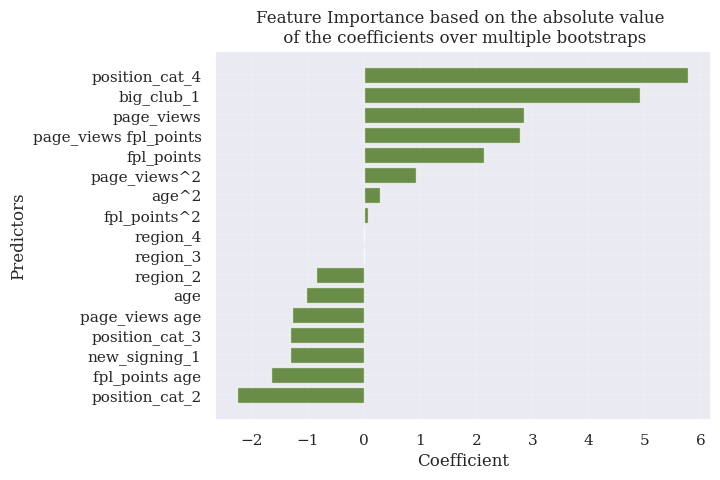

In [16]:
fig, ax = plt.subplots()
ax.barh(sorted_boot_beta_df['feature'].iloc[:-1], sorted_boot_beta_df['boot_mean'].iloc[:-1], 
        align='center', color="#336600", alpha=0.7)
ax.grid(linewidth=0.2)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Predictors')
ax.set_title('Feature Importance based on the absolute value \n of the coefficients over multiple bootstraps')
plt.show()

#### Now let's find the feature importance using the t-values 

In [17]:
# creating a new column with the t-values  
sorted_boot_beta_df['t'] = sorted_boot_beta_df.apply(lambda row: 
                                         row['boot_mean']/(row['boot_std']+0.001), axis=1)
sorted_boot_beta_df.head(2)

,feature,boot_mean,boot_std,95_low,95_high,t
10,position_cat_2,-2.26,2.03,-5.44,0.00,-1.112752
8,fpl_points age,-1.65,1.38,-3.31,0.78,-1.194786


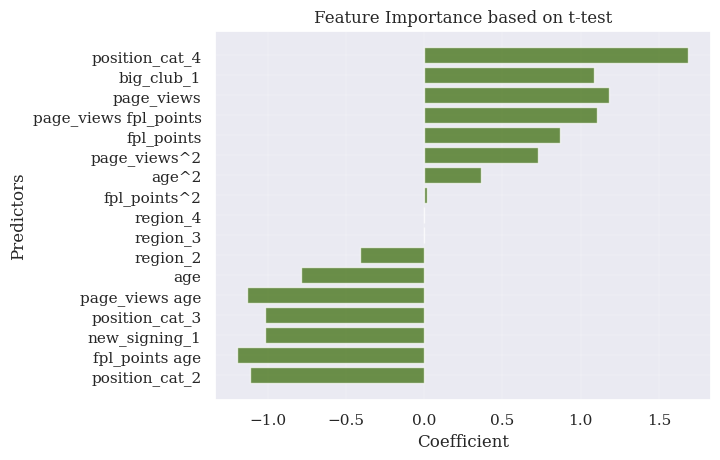

In [18]:
fig, ax = plt.subplots()
ax.barh(sorted_boot_beta_df['feature'].iloc[:-1], sorted_boot_beta_df['t'].iloc[:-1], 
        align='center', color="#336600", alpha=0.7)
ax.grid(linewidth=0.2)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Predictors')
ax.set_title('Feature Importance based on t-test')
plt.show()

<div id=coeff_interpretation style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>5 - Linear Regression Coefficient Interpretation</h1> 

Say we have input features $X$, which via some function $f()$, approximates outputs $Y$. That is, $Y = f(X) + \epsilon$.

- **Inference**: estimates the function $f$, and is more concerned with understanding the relationship between $X$ and $Y$.
- **Prediction**: the goal is making accurate $Y$ predictions for some unseen $X$.


#### Two popular and useful libraries in Python are `sklearn` and `statsmodels`.

`statsmodels` is mostly focused on the _inference_ task. It aims to make good estimates for $f()$ (via solving for our $\beta$'s), and it provides expansive details about its certainty. It provides lots of tools to discuss confidence, but isn't great at dealing with test sets.

`sklearn` is mostly focused on the _prediction_ task. It aims to make a well-fit line to our input data $X$, so as to make good $Y$ predictions for some unseen inputs $X$. It provides a shallower analysis of our variables. In other words, `sklearn` is great at test sets and validations, but it can't really discuss uncertainty in the parameters or predictions.

#### Let's try `statsmodels` now.

`statsmodels` linear regression does not include an intercept by default, so, if needed, we add one using:
```
Xtrain = sm.add_constant(Xtrain)
sm.OLS(y,Xtrain)
```
where Xtrain is our train set and y our return variable. 

Watch for additional intercepts coming from, e.g. Polynomial features. Have only one intercept. In our case we do have one, so we are not adding another one. 

#### Let's load a clean set of data

In [19]:
design_train_df = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")

design_test_df = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

In [20]:
import statsmodels.api as sm
from statsmodels.api import OLS

# TODO: fill in the input variable for add_constant()
design_train_df = sm.add_constant(design_train_df)
ols = OLS(y_train, np.array(design_train_df))
results = ols.fit()
# get the parameters
results.params 
design_train_df

,const,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,1.0,-0.378867,-0.705517,-0.689254,0.143541,0.267297,0.261136,0.497754,0.486280,0.475071,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.649806,-0.782937,-0.689254,0.422248,0.508758,0.447882,0.612991,0.539642,0.475071,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,-0.090449,0.533214,0.074738,0.008181,-0.048228,-0.006760,0.284317,0.039852,0.005586,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.558494,1.636458,-0.434590,0.311916,0.913952,-0.242716,2.677993,-0.711188,0.188868,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,1.0,0.271168,2.352598,-0.434590,0.073532,0.637948,-0.117847,5.534719,-1.022415,0.188868,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,1.0,0.318145,-0.008731,-0.179926,0.101216,-0.002778,-0.057242,0.000076,0.001571,0.032373,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
364,1.0,-0.244490,-0.105507,-0.179926,0.059776,0.025795,0.043990,0.011132,0.018983,0.032373,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
365,1.0,2.413552,2.217112,-0.434590,5.825233,5.351116,-1.048905,4.915587,-0.963534,0.188868,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
366,1.0,-0.381052,-1.092620,0.074738,0.145201,0.416345,-0.028479,1.193818,-0.081661,0.005586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Can we recover the feature names for readability?

In [21]:
feature_names = list(design_train_df.columns)
feature_names

['const',
 'page_views',
 'fpl_points',
 'age',
 'page_views^2',
 'page_views fpl_points',
 'page_views age',
 'fpl_points^2',
 'fpl_points age',
 'age^2',
 'position_cat_2',
 'position_cat_3',
 'position_cat_4',
 'new_signing_1',
 'big_club_1',
 'region_2',
 'region_3',
 'region_4']

In [22]:
results_df = pd.DataFrame(zip(feature_names, results.params), columns=['feature', 'coeff'])
results_df

,feature,coeff
0,const,8.123904
1,page_views,4.745999
2,fpl_points,2.881129
3,age,-1.274127
4,page_views^2,-0.213919
5,page_views fpl_points,1.137372
6,page_views age,-1.349853
7,fpl_points^2,0.794021
8,fpl_points age,-0.745141
9,age^2,-1.778397


It seems like they are almost the same as the ones produced by using `sklearn` (previous lab), so that is a good sanity check!

With `statsmodels` we can print more statistics than we need!
```
results.summary()
```
If we want human-readable feature names we need to set the parameter `xname`
```
results.summary(xname = a list of names)
```

In [23]:
results.summary(xname=feature_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           market_value   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     71.64
Date:                Sat, 04 Nov 2023   Prob (F-statistic):          9.34e-103
Time:                        15:32:23   Log-Likelihood:                -1161.8
No. Observations:                 368   AIC:                             2360.
Df Residuals:                     350   BIC:                             2430.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.1239      0.894      9.085      0.000       6.365       9.883
page_views                4.7460      0.848      5.597      0.000       3.078       6.414
fpl_points                2.8811      0.462      6.241      0.000       1.973       3.789
age                      -1.2741      0.357     -3.565      0.000      -1.977      -0.571
page_views^2             -0.2139      0.139     -1.537      0.125      -0.488       0.060
page_views fpl_points     1.1374      0.478      2.380      0.018       0.197       2.077
page_views age           -1.3499      0.357     -3.784      0.000      -2.051      -0.648
fpl_points^2              0.7940      0.471      1.686      0.093      -0.132       1.720
fpl_points age           -0.7451      0.421     -1.770      0.078      -1.573       0.083
age^2                    -1.7784      0.251     -7.080      0.000      -2.272      -1.284
position_cat_2            1.0799      0.875      1.234      0.218      -0.641       2.801
position_cat_3            0.0749      0.852      0.088      0.930      -1.601       1.750
position_cat_4            0.2505      1.226      0.204      0.838      -2.161       2.662
new_signing_1             1.8590      0.900      2.065      0.040       0.088       3.630
big_club_1                6.8700      0.921      7.457      0.000       5.058       8.682
region_2                  0.9875      0.739      1.337      0.182      -0.465       2.440
region_3                  1.5116      1.272      1.188      0.235      -0.990       4.013
region_4                  1.0376      1.052      0.986      0.325      -1.032       3.107
==============================================================================
Omnibus:                       48.147   Durbin-Watson:                   1.794
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.517
Skew:                           0.606   Prob(JB):                     1.02e-29
Kurtosis:                       5.691   Cond. No.                         25.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<div class="alert alert-success">
    <strong> 💬 DISCUSSION:</strong> How do the bootstrap confidence intervals compare with the ones derived by `statsmodels` which are based on the Student’s t-distribution? </div> 

<div class="alert alert-success">
    <strong> 💬 DISCUSSION:</strong> What conclusions can we make from the values of the model coefficients as to the relationship between our response variable y and the features? </div> 

```
y = 8.1 + 4.7 x page_views + 2.9 x fpl_points - 1.3 x age - 0.21 x page_views^2 + 1.1 x page_views fpl_points - 1.3 x page_views age + 0.79 x fpl_points^2 - 0.75 x fpl_points age - 1.8 x age^2 + 1.1 x position_cat_2 + 0.075 x position_cat_3 + 0.25 x position_cat_4 + 1.9 x new_signing_1 + 6.9 x big_club_1 + 0.99 x region_2 + 1.5 x region_3 + 1.0 x region_4
```


<div id=model style="border: thin solid black; background: lightsalmon; padding: 5px">
<h1>6 - Model Selection (review) with an example of ridge and lasso regression.</h1> 

We are interested in the generalization performance of a learning method which shows as the prediction capability on an independent test data. This performance guides our choice of learning model, and gives us a measure of the quality of the ultimately chosen model. If we are in a data-rich situation, the best approach for both problems is to randomly divide the dataset into three parts: a training set, a validation set, and a test set. The training set is used to fit the models; the validation set is used to estimate prediction error for model selection; the test set is used for assessment of the generalization error of the final chosen model.

- **Model selection**: estimating the performance of different models in order to choose the best one.
- **Model assessment**: having chosen a final model, estimating its predic- tion error (generalization error) on new data.
<p style="text-align:right"><font size="1"; text-align='right'>(The Elements of Statistical Learning (2009)</font></p>

#### Start with an original dataset 

![dataset](fig/data1.jpg) 

#### Split the original dataset and put the final test set away somewhere.

![valset](fig/data2.jpg) 

#### Create an additional validation set out of the train set

Why do we need a validation set? Why not just assess the model by training with different hyperparameters?

![crossval](fig/data3.jpg) 

#### Using cross validation

![jeffrey](fig/data4.jpg) 

### Ridge regression using a validation set. 

#### Let's load a clean set of data

In [24]:
design_train_df = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")

design_test_df = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

In [25]:
design_train_df.head(2)

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,-0.378867,-0.705517,-0.689254,0.143541,0.267297,0.261136,0.497754,0.486280,0.475071,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.649806,-0.782937,-0.689254,0.422248,0.508758,0.447882,0.612991,0.539642,0.475071,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
# remove
# Split the data into train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(design_train_df, 
                                                  y_train, 
                                                  train_size=0.8, 
                                                  random_state=42
                                                  )

X_train.shape, X_val.shape, y_train.shape, Y_val.shape

((294, 17), (74, 17), (368, 1), (74, 1))

In [27]:
# remove
# List of hyper-parameter values 
alphas = np.logspace(0, 1, 100)

# List to store training errors
training_error = []
# List to store validation errors
validation_error = []

fit_intercept = True

for i, alpha in enumerate(alphas):
    
    # For each i, fit a ridge regression on training set
    ridge_reg = Ridge(fit_intercept=fit_intercept, # TODO: define your bool varible here
                      alpha=alpha, # TODO: define your alpha here
                      #max_iter=max_iter
                     )
    ridge_reg.fit(X_train, Y_train) # TODO: fit your model

    # Predict on the train and validation set 
    Y_train_pred = ridge_reg.predict(X_train)
    Y_val_pred = ridge_reg.predict(X_val)
    
    # Compute the training and validation MSE
    mse_train = mean_squared_error(Y_train, Y_train_pred) 
    mse_val = mean_squared_error(Y_val, Y_val_pred)
    
    # Add that value to the list 
    training_error.append(mse_train) 
    validation_error.append(mse_val) 

In [28]:
# remove
# TODO: find the best parameter
# STEPS: 
# 1. Finds the minimum value in the validation_error list.
# 2. Finds the index of the smallest validation error in the validation_error list. 
# 3. Uses the index found in step 2 to retrieve the corresponding alpha value from the alphas list.
best_alpha = alphas[validation_error.index(min(validation_error))]
print(best_alpha)

10.0


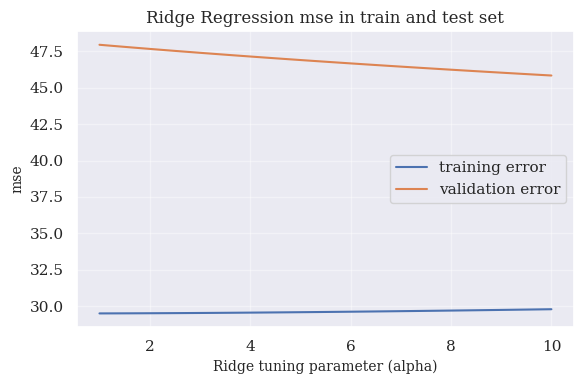

In [29]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(alphas, training_error, label='training error');
ax.plot(alphas, validation_error, label='validation error');

ax.set_xlabel('Ridge tuning parameter (alpha)', fontsize=10)
ax.set_ylabel('mse', fontsize=10)

ax.set_title('Ridge Regression mse in train and test set', fontsize=12)
ax.grid(":", alpha=0.4)

ax.legend(loc='best')
plt.tight_layout()

#### Let's re-fit the model on the whole dataset

In [30]:
# remove
# We should use all the dataset now, training+validation
# TODO: re-fit the model on the whole dataset using the best alpha
final_ridge_model = Ridge(alpha=best_alpha).fit(design_train_df, y_train)

#### Let's do the final assessment on the test set

In [31]:
# remove
y_test_pred = final_ridge_model.predict(design_test_df)
r2_test = final_ridge_model.score(design_test_df, y_test)
print(f'R^2 test = {r2_test:.3}')

R^2 test = 0.746


### Lasso regression using cross validation. 
<div class="alert alert-success">
<h3>Your turn! (5 mins)</h3> 

Complete the code inside the loop below. 

In [32]:
# remove
# Set parameters for cross-validation
alphas = np.logspace(0, 1, 100)
fit_intercept = True
# Maximum number of iterations to run 
# before it converges.
max_iter = 1000

lasso_coefficients = []
k = 5
num_est = 0
# store MSE results
results = []

training_error = []
validation_error = []
validation_std = []

for alpha in alphas:
    # TODO:
    # Initialize a Lasso regression model.
    # Hint: Lasso(fit_intercept=..., alpha=...)
    lasso_reg = Lasso(fit_intercept = fit_intercept, alpha = alpha)
    
    # Perform k-fold cross-validation using the Lasso regression model.
    # Hint: cross_validate(..., scoring="neg_mean_squared_error", 
    #                           return_train_score=True, 
    #                           return_estimator=True)
    lasso_cv = cross_validate(lasso_reg,
                design_train_df, 
                y_train, 
                cv=k, 
                              scoring="neg_mean_squared_error", 
                               return_train_score=True, 
                               return_estimator=True)
    
    training_error.append(                       
        np.mean(-lasso_cv['train_score'])
    )
    
    validation_error.append(
        np.mean(-lasso_cv['test_score'])
    )
    
    validation_std.append(
        np.std(lasso_cv['test_score'])
    )
    
    lasso_coefficients.append(
         lasso_cv['estimator']
    )

In [33]:
# find the best parameter
min_cross_val_mse = min(validation_error)
best_cross_val_alpha = alphas[validation_error.index(min_cross_val_mse)]
min_cross_val_mse, best_cross_val_alpha

(55.61005641992413, 1.0)

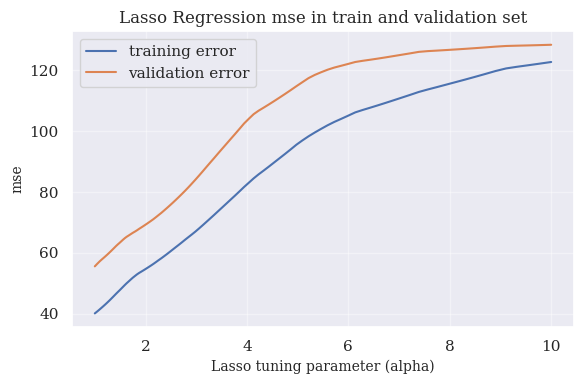

In [34]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(alphas, training_error, label='training error');
ax.plot(alphas, validation_error, label='validation error');

ax.set_xlabel('Lasso tuning parameter (alpha)', fontsize=10)
ax.set_ylabel('mse', fontsize=10)

ax.set_title('Lasso Regression mse in train and validation set', fontsize=12)
ax.grid(":", alpha=0.4)

ax.legend(loc='best')
plt.tight_layout()

#### Let's re-fit the model on the whole dataset

In [35]:
# We should use all the dataset now, training+validation

# TODO: complete the code below
cross_ridge_model = Ridge(alpha=best_cross_val_alpha).fit(design_train_df, y_train)

#### Evaluate on the test set

In [36]:
# remove
y_test_pred = cross_ridge_model.predict(design_test_df)
r2_test = cross_ridge_model.score(design_test_df, y_test)
print(f'R^2 test = {r2_test:.3}')

R^2 test = 0.745


### Ridge and lasso regression using built-in cross validation in `sklearn`

In [37]:
design_train_df = pd.read_csv("data/design_train_df.csv")
y_train = pd.read_csv("data/y_train.csv")

design_test_df = pd.read_csv("data/design_test_df.csv")
y_test = pd.read_csv("data/y_test.csv")

In [38]:
design_train_df.head(2)

,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,-0.378867,-0.705517,-0.689254,0.143541,0.267297,0.261136,0.497754,0.486280,0.475071,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.649806,-0.782937,-0.689254,0.422248,0.508758,0.447882,0.612991,0.539642,0.475071,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [39]:
# Set parameters for cross-validation
alphas = np.logspace(0, 1, 10)

fit_intercept = True
max_iter = 100000

ridge_coefficients = []
lasso_coefficients = []
k = 10

ridge = RidgeCV(alphas=alphas, cv=k).fit(design_train_df, y_train)
lasso = LassoCV(alphas=alphas, cv=k).fit(design_train_df, y_train)

ridge_a = ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print(f'R^2 score for Ridge with alpha={ridge_a}: {ridge.score(design_test_df, y_test):.3}')

lasso_a = lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print(f'R^2 score for Lasso with alpha={lasso_a}: {lasso.score(design_test_df, y_test):.3}')

Best alpha for ridge: 10.0
R^2 score for Ridge with alpha=10.0: 0.746
Best alpha for lasso: 1.0
R^2 score for Lasso with alpha=1.0: 0.765
